# **DBSCAN**

## **Implementacion**

In [80]:
import numpy as np
import matplotlib.pyplot as plt

from math import e, inf
from random import randint, uniform
from sklearn.datasets import make_circles

### KNN

In [81]:
class Node:
  def __init__(self, parent, x, area):
    self.parent = parent
    self.x = x
    self.childs = [None, None]  # [left_child, right_child]
    # El area es un vector 2*len(x)-dimensional y representa un hipercubo, donde cada
    # par de elementos representan los valores minimos y maximos de una determinada coordenada.
    # Por ejemplo, si len(x) == 2, entonces area = [a, b, c, d] representa el cuadrado:
    #      a <= x[0] <= b;    c <= x[1] <= d
    self.area = area

class KNN:
  def __init__(self, X):
    self.X = X
    
  def d(self, x, y):
    """ Distancia euclidiana entre dos vectores. """
    return np.linalg.norm(x-y)
    
  def build_kd_tree(self, X=None, parent=None, right=True, d=0, root=True, area=None):
    """ Construimos un KD-Tree.
    INPUT:
        X: Conjunto de datos del nodo actual.
        parent: Nodo padre del nodo actual.
        right: Indica si el nodo actual es el hijo derecho.
        d: Atributo que se usara para realizar la division binaria de los datos.
        root: Indica si el nodo actual es la raiz de todo el arbol.
        area: Area que representa el nodo actual.
    """
    # Si el nodo es la raiz, entonces tomamos todos los datos y el area es todo el espacio.
    if root: 
      X = self.X
      area = [-inf,inf]*len(X[0])
        
    # Si no hay elementos, no se crea ningun nodo
    if len(X) == 0: return
    # Si solo hay un elemento, creamos un nodo con ese unico elemento.
    elif len(X) == 1:
      node = Node(parent, X[0], area)
      # Verificamos que el nodo no sea la raiz, lo que significaria que solo hay un dato.
      if not root: parent.childs[int(right)] = node
    # Si hay mas de un dato.
    else:
      # Ordenamos los elementos segun el d-esimo atributo.
      X_c = X.copy()
      X_c.sort(key = lambda x: x[d])
      # Obtenemos la mediana.
      m = int(len(X_c)/2)
      x_m = X_c[m]
      # Creamos un nuevo nodo donde se almacenara la mediana.
      node = Node(parent, x_m, area)
      if not root: parent.childs[int(right)] = node
      else: self.kd_tree = node
      # Llamamos recursivamente la funcion para los hijos izquierdo y derecho.
      # Derecho
      X_r = X_c[m+1:].copy()
      area_r = area.copy()
      area_r[2*d] = x_m[d]
      # Izquierdo
      X_l = X_c[:m].copy()
      area_l = area.copy()
      area_l[2*d+1] = x_m[d]
      # Llamada recursiva
      self.build_kd_tree(X_l, node, False, (d+1)%len(x_m), False, area_l)
      self.build_kd_tree(X_r, node, True, (d+1)%len(x_m), False, area_r)
    
  def radius_neighbors(self, x, r):
    # Aqui almacenamos los vecinos
    self.neighbors = []

    self.r_neighbors(x, self.kd_tree, 0, r)

    neighbors = self.neighbors
    # Nos aseguramos de eliminar estos atributos.
    self.neighbors = None
    return neighbors

  def r_neighbors(self, x, node, d, r):
    # Verificamos si el punto se encuentra fuera del hipercubo definido por el nodo actual.
    if not all(node.area[2*i] <= x[i] <= node.area[2*i+1] for i in range(len(x))):
      # Por cada dimension, verificamos si el punto se encuentra dentro de los lados
      # correspondientes al hipercubo
      p = []
      for i in range(len(x)):
        # Si no es asi, almacenamos la coordenada del punto que se encuentra fuera del
        # lado del hipercubo.
        if node.area[2*i] > x[i]: p.append(node.area[2*i])
        elif x[i] > node.area[2*i+1]: p.append(node.area[2*i+1])
        else: p.append(x[i])
        
            
      # Calculamos la distancia entre las coordenadas del punto fuera del hipercubo y
      # la interseccion de los lados correspondientes. Si es mayor al radio, no necesitamos
      # verificar mas esta rama.
      dist = self.d(np.array(p), x)
      if dist > r: return
        
    # Calculamos la distancia entre el punto y la raiz actual. Verificamos si es menor
    # que el raio
    dist = self.d(x, node.x)
    if dist < r: self.neighbors.append(node.x)
        
    # Llamamos primero a la subdivision del arbol tal que el punto cumpla la condicion,
    # con la esperanza de que al llamar el segundo hijo, este pueda ser descartado facilmente.
    # Si no cumple ninguna, se recorre primero el hijo izquierdo (si no es nulo) y luego el derecho.
    if x[d] <= node.area[2*d+1] and node.childs[0] != None: 
      self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
      if node.childs[1] != None:
        self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
        
    elif x[d] >= node.area[2*d] and node.childs[1] != None: 
      self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
      if node.childs[0] != None:
        self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
    
    elif node.childs[0] != None: 
      self.r_neighbors(x, node.childs[0], (d+1)%len(x), r)
      if node.childs[1] != None:
        self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)
        
    elif node.childs[1] != None:
      self.r_neighbors(x, node.childs[1], (d+1)%len(x), r)

### **DBScan**

In [89]:
class DBS:
  def __init__(self, X):
    self.X = X
    # Usaremos el KNN para obtener los vecinos
    self.knn = KNN(X)
    self.knn.build_kd_tree()

  def d(self, x, y):
    """ Distancia Euclidiana. """
    return np.linalg.norm(x-y)

  def query(self, x, dist):
    """ Calculamos los vecinos de un elemento dada una distancia minima. """
    return self.knn.radius_neighbors(x, dist)

  def clustering(self, dist, min_x):
    """ Agrupamos los datos usando el metodo de DBScan. """
    # Contador de clusters.
    C = -1
    # Diccionario  label[x] -> C  tal que   x in C
    labels = {tuple(x) : None for x in self.X}
    
    for x in self.X:
      # Si el elemento ya fue etiquetado, pasamos al siguiente.
      if labels[tuple(x)] != None: continue
      neighbors = self.query(x, dist)
    
      # Si el elemento no tiene suficientes vecinos, es un dato atipico.
      if len(neighbors) < min_x:
        labels[tuple(x)] = -1
        continue
        
      # Pasamos a un nuevo cluster, etiquetamos el elemento con el cluster actual.
      C += 1
      labels[tuple(x)] = C
      # Sacamos al elemento de sus propios vecinos y creamos el conjunto semilla.
      for i in range(len(neighbors)):
        if np.equal(neighbors[i], x).all(): 
            neighbors.pop(i)
            break
      seed_set = neighbors.copy()
        
      for s in seed_set:
        # Si el elemento fue consierado atipico, ahora sera etiquetado con el
        # cluster actual.
        if labels[tuple(s)] == -1: labels[tuple(s)] = C
        # Si ya tiene etiqueta, pasamos al siguiente elemento.
        if labels[tuple(s)] != None: continue
            
        # Etiquetamos al elemento con el cluster actual.
        labels[tuple(s)] = C
        # Calculamos los vecinos del elemento.
        neighbors = self.query(s, dist)
        # Si el elemento tiene suficientes vecinos.
        if len(neighbors) >= min_x:
          # Unimos los conjuntos "neighbors" y "seed_set"
          for n in neighbors: 
            if not any(np.equal(n, ss).all() for ss in seed_set): seed_set.append(n)
                
    return labels
    

## **Lectura de Datos**

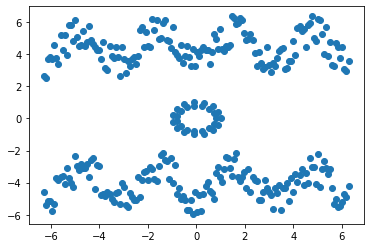

In [90]:
nb_samples = 150

X0 = np.expand_dims(np.linspace(-2 * np.pi, 2 * np.pi, nb_samples), axis=1)
Y0 = -5 - np.cos(2.0 * X0) + np.random.uniform(0.0, 2.0, size=(nb_samples, 1))
 
X1 = np.expand_dims(np.linspace(-2 * np.pi, 2 * np.pi, nb_samples), axis=1)
Y1 = 3.5 - np.cos(2.0 * X0) + np.random.uniform(0.0, 2.0, size=(nb_samples, 1))
 
data_0 = np.concatenate([X0, Y0], axis=1)
data_1 = np.concatenate([X1, Y1], axis=1)
data = np.concatenate([data_0, data_1], axis=0)
data = [d for d in data]
for c in make_circles(30)[0]: data.append(c)

plt.plot([d[0] for d in data], [d[1] for d in data], 'o')
plt.show()


## **Resultados**

In [93]:
dbs = DBS(data)
labels = dbs.clustering(1.5, 5)

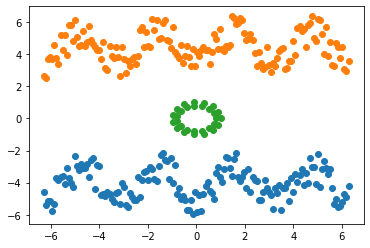

In [94]:
clusters = [[] for _ in range(max(labels.values())+2)]
for x in labels:
  clusters[labels[tuple(x)]].append(x)
for c in clusters:
  plt.plot([x[0] for x in c], [x[1] for x in c], 'o')
plt.show()